### MNIST Classification has been identified as to easy for ML classification

In [9]:
# from sklearn.datasets import fetch_openml
# mnist = fetch_openml('mnist_784', as_frame=False)
from sklearn.datasets import load_digits

digits = load_digits()

X, y = digits.data, digits.target
X

array([[ 0.,  0.,  5., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 16.,  9.,  0.],
       ...,
       [ 0.,  0.,  1., ...,  6.,  0.,  0.],
       [ 0.,  0.,  2., ..., 12.,  0.,  0.],
       [ 0.,  0., 10., ..., 12.,  1.,  0.]])

In [10]:
X.shape

(1797, 64)

In [11]:
y

array([0, 1, 2, ..., 8, 9, 8])

In [12]:
y.shape

(1797,)

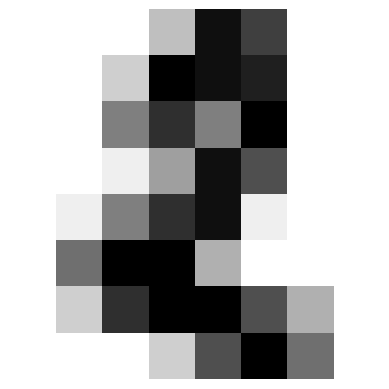

In [25]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(8, 8)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[2]
plot_digit(some_digit)
plt.show()

In [26]:
y[2]

2

In [27]:
X_train, X_test, y_train, y_test = X[:1500], X[1500:], y[:1500], y[1500:]

### Binary classifier is it a 8 or not.

In [38]:
y_train_8 = (y_train == 8)
y_test_8 = (y_test == 8)

In [40]:
y_train_8

array([False, False, False, ..., False, False, False])

In [42]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_8)

SGDClassifier(random_state=42)

In [47]:
sgd_clf.predict([some_digit]) # False

array([False])

In [48]:
sgd_clf.predict([X[8]]) # we know this digit is 8

array([ True])

In [50]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_8, cv=3, scoring="accuracy")

array([0.912, 0.948, 0.954])

If your model performs worse than DummyClassifier, it indicates your model isn't learning effectively.

In [52]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_8)
any(dummy_clf.predict(X_train))

False

In [53]:
cross_val_score(dummy_clf, X_train, y_train_8, cv=3, scoring="accuracy")

array([0.904, 0.902, 0.902])

Accuracy to measure a classifier is not preferred especially with skewed datasets (classes are much more fequent than others) performance of a classifier is to look at the Confusion Matrix

### Custom Cross-Validation

In [55]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if data isn't already shuffled

for train_index, test_index in skfolds.split(X_train, y_train_8):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_8[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_8[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.912
0.948
0.954


### Confusion Matrices

In [56]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3)

In [57]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_8, y_train_pred)
cm

array([[1300,   54],
       [  39,  107]])

first row negatives: 
- 1300 are correctly non 8's (true-negatives)
- 54 wrongly classified as 8's (false-positives type 1 errors)
  
second row positives:
- 39 are wrong non 8's (false-negatives type 2 errors)
- 107 correctly 8's (true-positives)

A perfect
classifier would only have true positives and true negatives, so its confusion matrix
would have nonzero values only on its main diagonal (top left to bottom right)

In [58]:
y_train_perfect_predictions = y_train_8
confusion_matrix(y_train_8, y_train_perfect_predictions)

array([[1354,    0],
       [   0,  146]])

precision = TP/TP+FP (True Positive, False Positive)

recall = TP/TP+FN

In [59]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_8, y_train_pred) # 107 / (54 + 107)

0.6645962732919255

In [60]:
recall_score(y_train_8, y_train_pred) # 107 / (39 + 107)

0.7328767123287672

### F1 score = 2/(1/percision)+1/(recall) = 2 * (precision * recall)/(precision + recall)

### = TP/TP + ((FN + FP)/2)

In [61]:
from sklearn.metrics import f1_score
f1_score(y_train_8, y_train_pred)

0.6970684039087948

F1 score favors classifiers that have similar precision and recall

Although in some context you may want high precision and low recall, also low precision high recall

### looking at particular scores based on a threshold

`SGDClassifier` uses a threshold of 0

In [66]:
y_scores = sgd_clf.decision_function([X[8]])
y_scores

array([395.74579601])

In [67]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

deciding on a threshold

In [68]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_8, cv=3, method="decision_function")

In [69]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_8, y_scores)

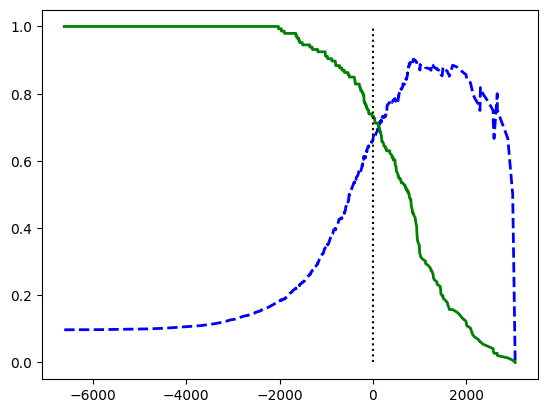

In [70]:
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.show()

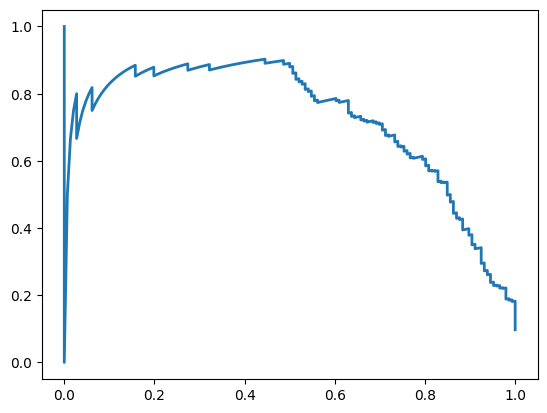

In [71]:
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")
plt.show()

In [74]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision]
threshold_for_90_precision

865.9528259046472

In [75]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [76]:
precision_score(y_train_8, y_train_pred_90)

0.9027777777777778

In [77]:
recall_at_90_precision = recall_score(y_train_8, y_train_pred_90)
recall_at_90_precision

0.4452054794520548

^ This isn't a good classifier if recall is low

if someone says 99% precision, ask "At what recall"

### reciever operating characteristic (ROC curve)

plots true positive rate (TPR) against false positive (FPR)

FPR also called the fall-out is the ratio negative instances that are incorrectly classified as positive = 1 - TNR (true negative rate)

ROC curve plots sensitivity (recall) versus 1 - specificity

In [78]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_8, y_scores)

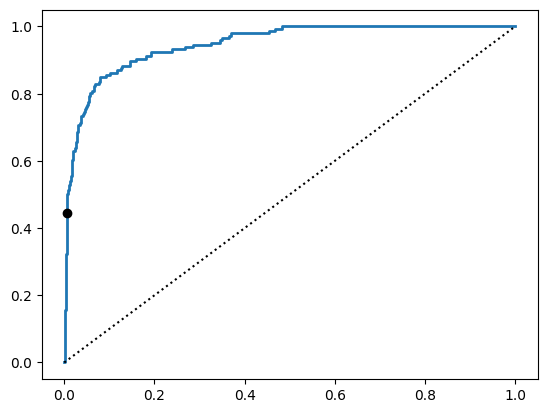

In [79]:
# thresholds are in decreasing order so we use <= instead of >=
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]

plt.plot(fpr, tpr, linewidth=2, label="ROC curve")
plt.plot([0,1], [0,1], 'k:', label="Random classifier's ROC curve")
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision")
plt.show()

A perfect classifier will have a ROC AUC (area under curve) equal to 1, a purely random classifier will have a ROC AUC equal to 0.5

In [81]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_8, y_scores)

0.9483114465510611

you should prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives. Otherwise, use the ROC curve.

In [82]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

In [83]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_8, cv=3, method="predict_proba")

estimated probabilities, not actual probabilities:

In [84]:
y_probas_forest[:2]

array([[1.  , 0.  ],
       [0.91, 0.09]])

second column contains the estimated probabilities for the positive class

In [92]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_8, y_scores_forest
)

ValueError: too many values to unpack (expected 2)

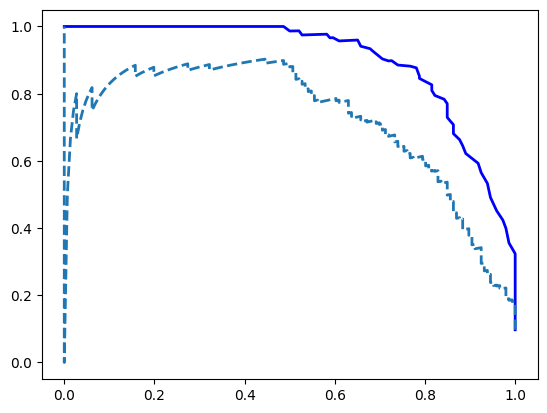

In [88]:
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")
plt.show()

^ Random Forest is superior to SGD!

In [96]:
y_pred_forest = y_scores_forest >= 0.5  # Positive class if probability ≥ 50%

y_train_pred_forest = y_probas_forest[:, 1] >= 0.5
f1_score(y_train_8, y_pred_forest)

0.7074235807860262

In [97]:
roc_auc_score(y_train_8, y_scores_forest)

0.9828741830395986